[('PeriodicPower', 'blackschole', 3, 0.32, 493.59, 1.75), ('PeriodicPower', 'streamcluster', 2, 0.28, 2311.19, 1.65), ('PeriodicThermal', 'canneal', 1, 49.0, 2786362.78, 126.62), ('PeriodicPower', 'blackschole', 1, 0.25, 641.8, 1.69), ('PeriodicThermal', 'streamcluster', 2, 54.9, 611364.59, 139.86), ('PeriodicThermal', 'streamcluster', 3, 58.23, 460313.02, 137.79), ('PeriodicThermal', 'canneal', 2, 49.2, 2538411.22, 126.39), ('PeriodicThermal', 'swaptions', 2, 57.32, 341051.65, 170.35), ('PeriodicPower', 'swaptions', 2, 0.32, 1469.01, 1.92), ('PeriodicThermal', 'blackschole', 1, 51.62, 228164.3, 161.97), ('PeriodicPower', 'swaptions', 3, 0.35, 1382.56, 1.92), ('PeriodicThermal', 'swaptions', 3, 60.52, 272649.56, 170.3), ('PeriodicPower', 'streamcluster', 3, 0.32, 2146.37, 1.55), ('PeriodicThermal', 'streamcluster', 1, 51.26, 1054325.27, 145.35), ('PeriodicThermal', 'blackschole', 2, 54.86, 139901.77, 162.09), ('PeriodicPower', 'canneal', 2, 0.15, 5004.18, 1.54), ('PeriodicThermal', 'ca

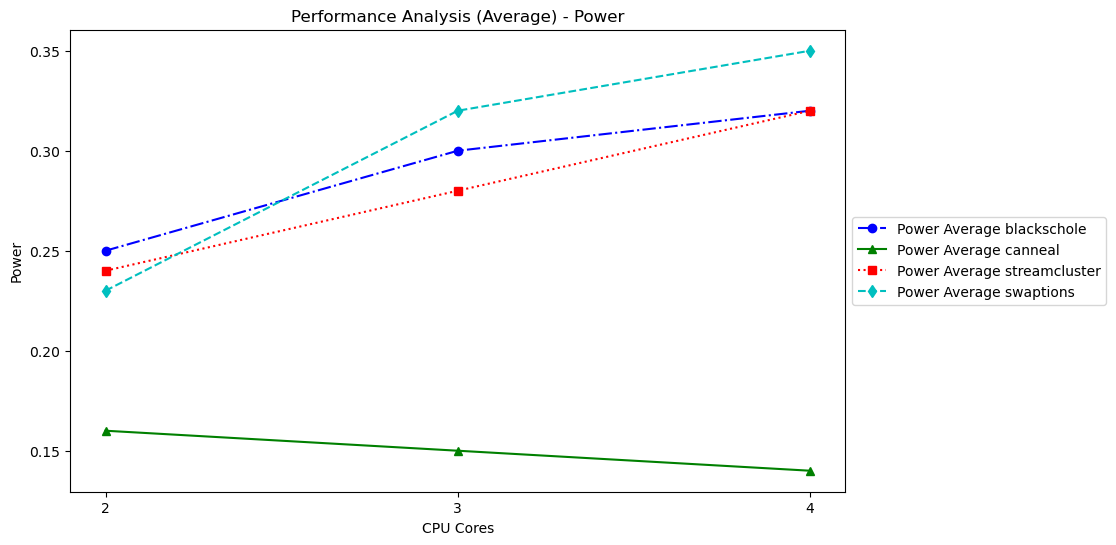

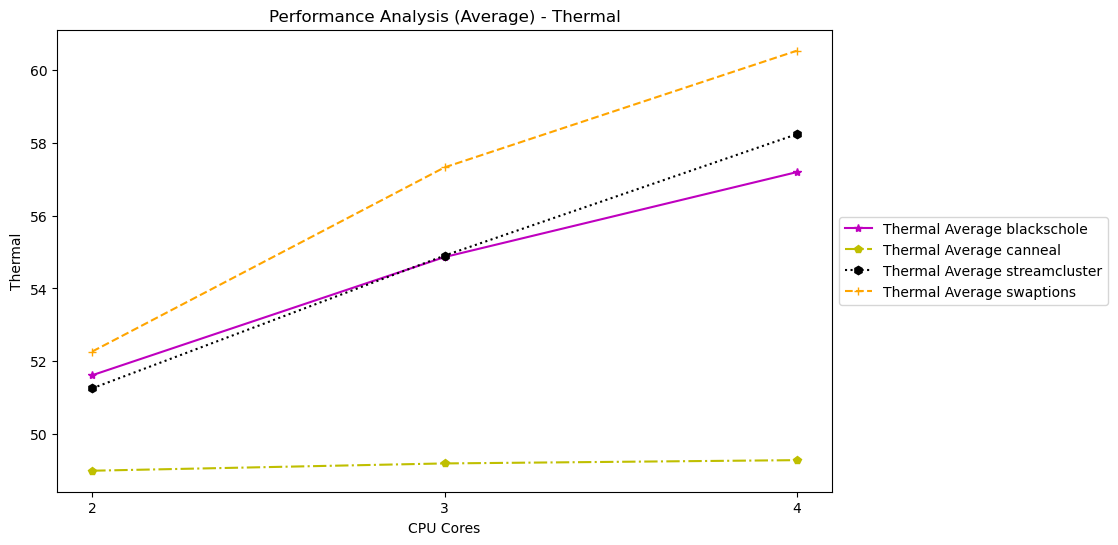

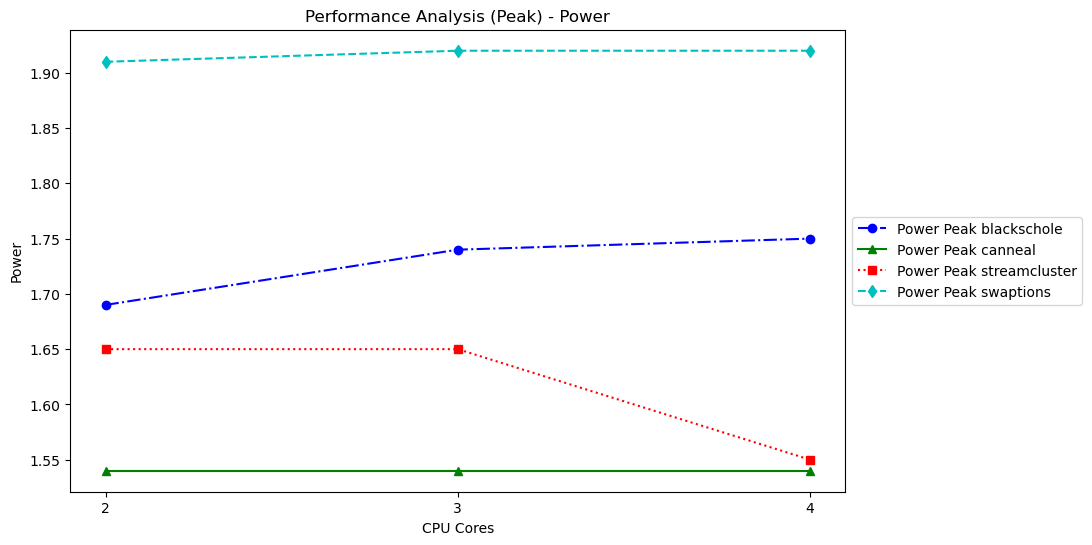

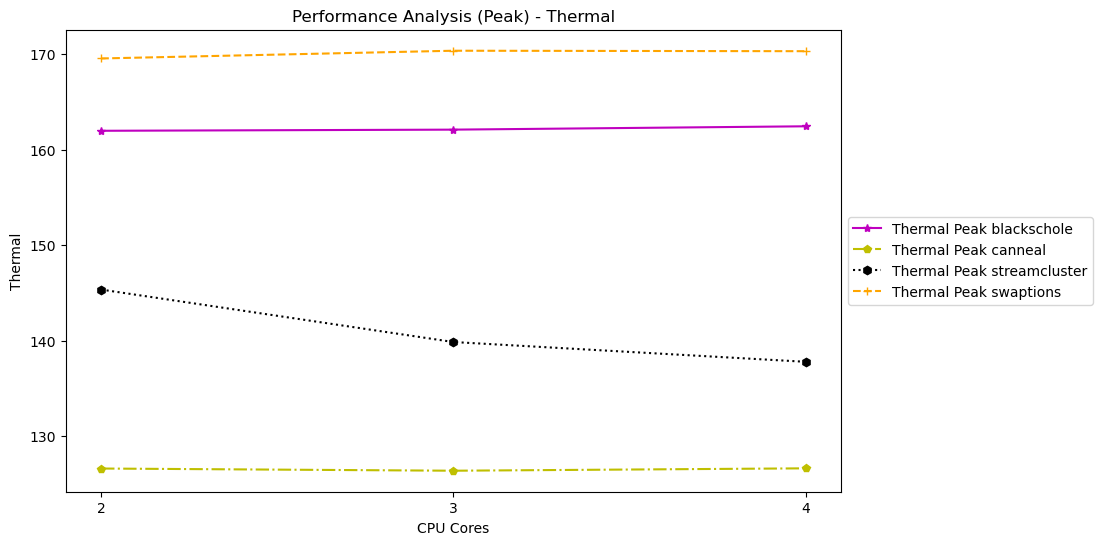

In [4]:
import pandas as pd
import numpy as np
import os

def calculate_metrics(logfile_path):
    try:
        # Read the data, skipping the first row (head line)
        df = pd.read_csv(logfile_path, sep='\s+', header=None, skiprows=1)
    except Exception as e:
        print(f"Error reading {logfile_path}: {e}")
        return None

    if df.empty:
        return None

    # select the largest n values
    peak_values = df.stack().nlargest(10)
    peak = round(peak_values.mean(), 2)

    # Calculate average and sum, ignore data less than 0.1
    filtered_df = df[df >= 0.01]
    avg = round(filtered_df.mean().mean(), 2)
    total_sum = round(filtered_df.sum().sum(), 2)

    return avg, total_sum, peak

def process_log_files(directory):
    results = []
    if not os.path.exists(directory):
        print("Directory does not exist")
        return results

    for filename in os.listdir(directory):
        if filename.endswith(".log"):
            filepath = os.path.join(directory, filename)
            parts = filename.split('_')
            tag = parts[0]
            project = parts[1]
            core_count = int(parts[2].split('.')[0])

            metrics = calculate_metrics(filepath)
            if metrics:
                avg, total_sum, peak = metrics
                result_object = (tag, project, core_count, avg, total_sum, peak)
                results.append(result_object)

    return results

log_directory = "./logs"
processed_results = process_log_files(log_directory)
print(processed_results)


import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from collections import defaultdict

def plot_axes(data, y_label, x_label, title):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Define line styles and markers
    linestyle = ['-.', '-', ':', '--', '-', '-.', ':', '--', '-', '-.']
    markers = ['o', '^', 's', 'd', '*', 'p', 'h', '+', 'x', 'v', '1', '2', '3', '4']
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']  # Add more colors

    for metric, dataset in data.items():
        for index, (label, values) in enumerate(sorted(dataset.items())):
            if y_label in label:
                values = sorted(values, key=lambda x: x[0])  # Sort by CPU cores
                x_values = [v[0]+1 for v in values]
                y_values = [v[1] for v in values]

                line_color = colors[index % len(colors)]
                ax.plot(x_values, y_values, label=f'{y_label} {metric} {label.split()[-1]}',
                        marker=markers[index % len(markers)], linestyle=linestyle[index % len(linestyle)], color=line_color)

    # Place the legend outside of the plot area
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))  # Only display integer ticks
    plt.title(title)
    plt.savefig(f'{title}.pdf', bbox_inches='tight')  # Save the figure as a PDF file
    plt.show()

metrics_data = {'Average': defaultdict(list), 'Peak': defaultdict(list)}

for tag, project, core, avg, total_sum, peak in processed_results:
    metrics_data['Average'][f'{tag} {project}'].append((core, avg))
    metrics_data['Peak'][f'{tag} {project}'].append((core, peak))

for metric, data in metrics_data.items():
    plot_axes({metric: data}, 'Power', 'CPU Cores', f'Performance Analysis ({metric}) - Power')
    plot_axes({metric: data}, 'Thermal', 'CPU Cores', f'Performance Analysis ({metric}) - Thermal')
